<a href="https://colab.research.google.com/github/skillnerve/DataScience-Projects/blob/main/Swin_Transformer_on_trashnet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intro

We aim to classify waste into the following categories using Pre trained Swin transformer which was trained over Trash net data set.
  1)glass
  2)metal
  3)plastic
  4)trash
  5)paper
  6)cardboard

The model takes image and tells us the probabilities of the item in the image being glass, metal , plastic, trash,paper,cardboard.

# Libraries

In [1]:
!git clone https://github.com/rishigami/Swin-Transformer-TF

Cloning into 'Swin-Transformer-TF'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 39 (delta 13), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image  as img
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
import keras.backend as K
from tqdm import tqdm
import sys
sys.path.append('/content/Swin-Transformer-TF')
from swintransformer import SwinTransformer
from sklearn.model_selection import StratifiedKFold
import zipfile
import os

In [3]:
!wget --no-check-certificate \
    "https://github.com/garythung/trashnet/archive/refs/heads/master.zip" \
    -O "/tmp/trash.zip"

--2022-01-13 05:03:31--  https://github.com/garythung/trashnet/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/garythung/trashnet/zip/refs/heads/master [following]
--2022-01-13 05:03:31--  https://codeload.github.com/garythung/trashnet/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/trash.zip’

/tmp/trash.zip          [    <=>             ]  40.63M  18.0MB/s    in 2.3s    

2022-01-13 05:03:34 (18.0 MB/s) - ‘/tmp/trash.zip’ saved [42609514]



# Data

In [5]:
!unzip /tmp/trash.zip

Archive:  /tmp/trash.zip
4649cc67cfbe1a182d84e8d7f26b02daba48b4e5
   creating: trashnet-master/
  inflating: trashnet-master/.gitignore  
  inflating: trashnet-master/DataLoader.lua  
  inflating: trashnet-master/LICENSE  
  inflating: trashnet-master/README.md  
   creating: trashnet-master/data/
  inflating: trashnet-master/data/constants.py  
  inflating: trashnet-master/data/dataset-resized.zip  
  inflating: trashnet-master/data/one-indexed-files-notrash_test.txt  
  inflating: trashnet-master/data/one-indexed-files-notrash_train.txt  
  inflating: trashnet-master/data/one-indexed-files-notrash_val.txt  
  inflating: trashnet-master/data/one-indexed-files.txt  
  inflating: trashnet-master/data/resize.py  
  inflating: trashnet-master/data/zero-indexed-files.txt  
  inflating: trashnet-master/model.lua  
  inflating: trashnet-master/plot.lua  
  inflating: trashnet-master/shuffle.lua  
  inflating: trashnet-master/test.lua  
  inflating: trashnet-master/train.lua  
  inflating: tr

In [6]:
!unzip /content/trashnet-master/data/dataset-resized.zip

Archive:  /content/trashnet-master/data/dataset-resized.zip
   creating: dataset-resized/
  inflating: dataset-resized/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset-resized/
  inflating: __MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/cardboard/
  inflating: dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset-resized/cardboard/cardboard108.jpg  
  inflating: dataset-resized/cardboard/cardboard109.jpg  
  inflating: dataset-r

In [7]:
df=pd.DataFrame(columns=['Link','Label'])
dir_path='/content/dataset-resized'
q=0
print(list(os.listdir(dir_path)))
for i in tqdm(os.listdir(dir_path)):
  if i != '.DS_Store':
    for j in os.listdir(dir_path+'/'+i):
      df=df.append({'Link':str(dir_path+'/'+i+'/'+j),'Label':i},ignore_index=True)

['glass', 'metal', 'plastic', 'trash', 'paper', '.DS_Store', 'cardboard']


100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


In [8]:
df

,Link,Label
0,/content/dataset-resized/glass/glass489.jpg,glass
1,/content/dataset-resized/glass/glass102.jpg,glass
2,/content/dataset-resized/glass/glass499.jpg,glass
3,/content/dataset-resized/glass/glass265.jpg,glass
4,/content/dataset-resized/glass/glass62.jpg,glass
...,...,...
2522,/content/dataset-resized/cardboard/cardboard56...,cardboard
2523,/content/dataset-resized/cardboard/cardboard17...,cardboard
2524,/content/dataset-resized/cardboard/cardboard28...,cardboard
2525,/content/dataset-resized/cardboard/cardboard34...,cardboard


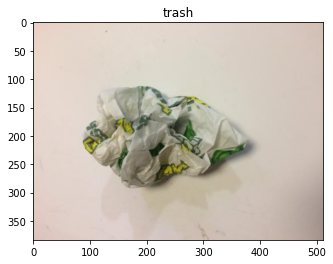

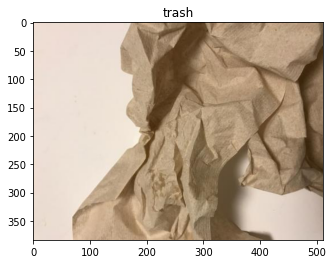

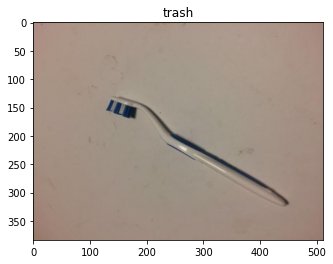

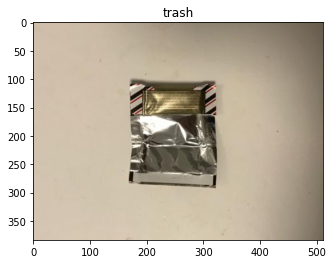

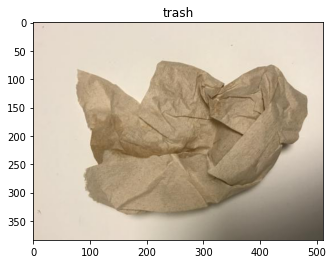

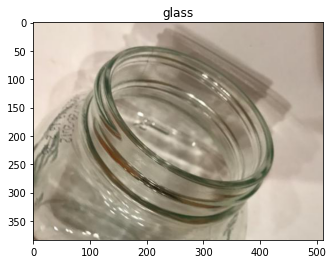

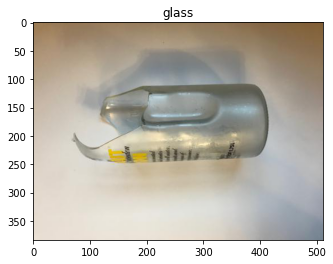

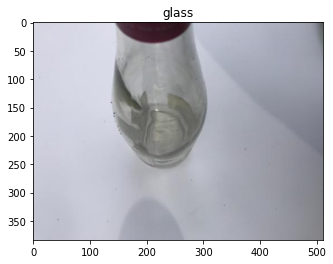

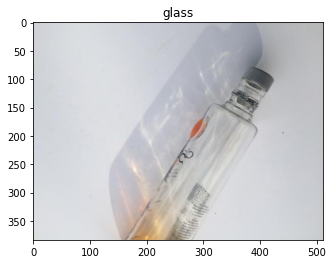

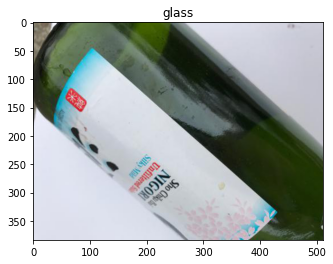

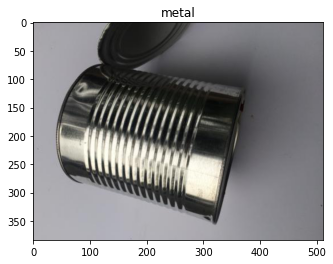

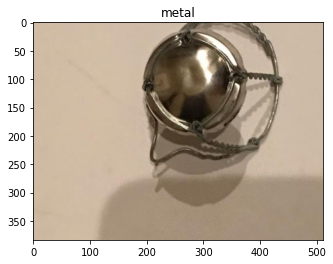

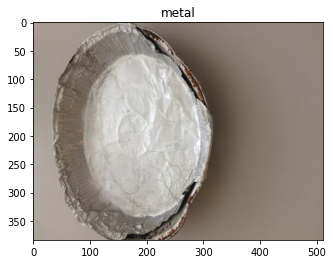

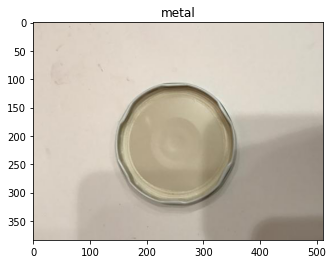

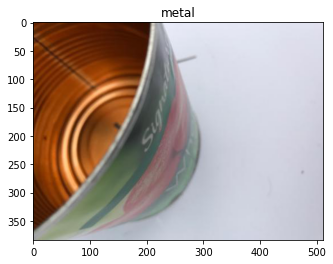

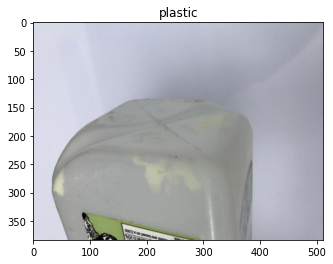

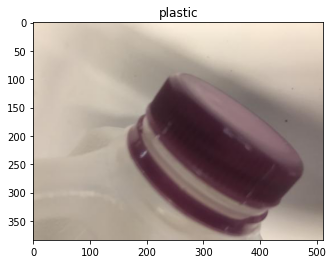

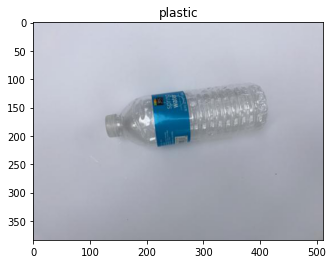

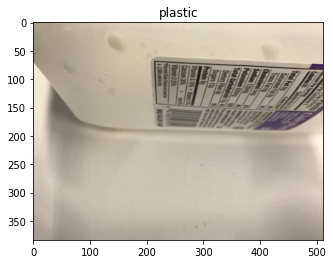

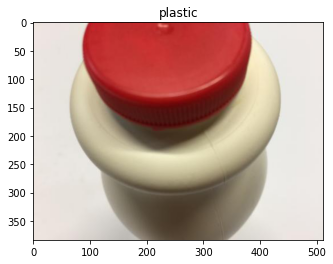

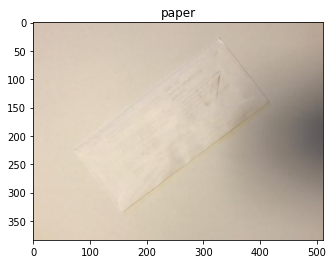

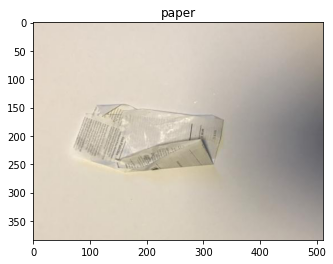

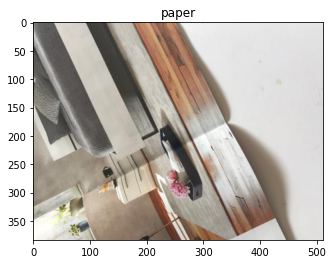

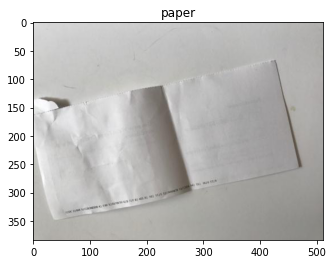

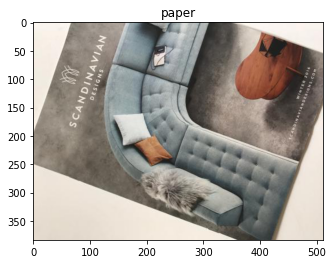

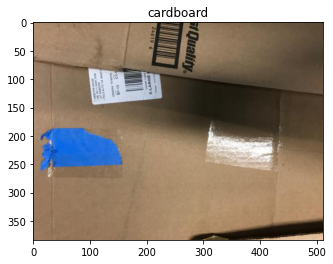

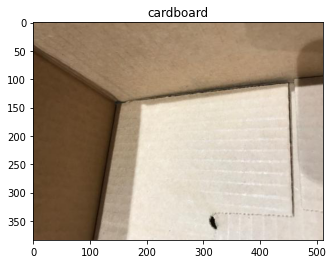

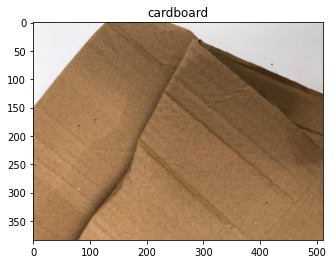

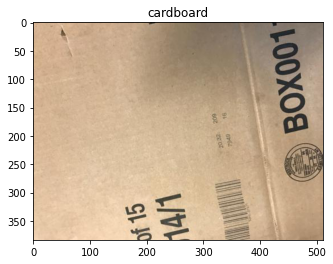

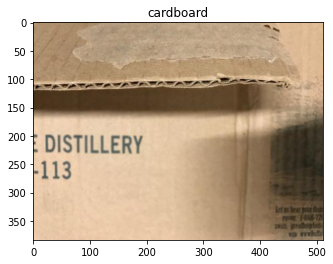

In [14]:
q=list(set(df['Label']))
for i in q:
  for k in range(5):
    j=Image.open(df[df.Label==i]['Link'].reset_index(drop=True).iloc[k])
    plt.imshow(j)
    plt.title(df[df.Label==i]['Label'].reset_index(drop=True).iloc[k])
    plt.show()

In [15]:
ys=set(df['Label'])
q=0
for i in ys:
  df.loc[df.Label==i,'Label']=q
  q+=1

In [16]:
labels=dict(df[['Link','Label']].values)

In [17]:
labels['/content/dataset-resized/plastic/plastic145.jpg']

3

# Data Generators

In [18]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, list_IDs, labels, batch_size=10, n_channels=1, shuffle=False):
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp      = [self.list_IDs[k] for k in indexes]
        
        x, y = self.__data_generation(list_IDs_temp)
        return x, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        x           = np.zeros((self.batch_size,224,224,3))
        y           = np.zeros((self.batch_size,1))
        for i, ID in enumerate(list_IDs_temp):
            x[i]                =Image.open(ID).resize((224,224))
            y[i]                =self.labels[ID]
            
        return x,tf.keras.utils.to_categorical(y,6)

# CallBack

In [20]:
class CustomCallBacks(tf.keras.callbacks.Callback):
    
    def __init__(self,n):
        self.n=n
    
    def on_train_begin(self, logs={}):
        self.loss     ={'loss':[]}
        self.val_loss ={'loss':[]}
        self.epoch    =None
        self.b        =0
        self.c        =0
        self.min_t    =None 
        
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch=epoch
#         if self.epoch>=1:
#             lr=tf.keras.backend.get_value(self.model.optimizer.lr)
#             tf.keras.backend.set_value(self.model.optimizer.lr,lr*0.10)

    def on_epoch_end(self, epoch, logs={}):
        print('{} ended'.format(epoch))
        self.loss['loss'].append(logs.get('loss'))
        self.val_loss['loss'].append(logs.get('loss'))
        if self.epoch==0:
            self.model.save_weights('model'+str(self.n)+'.h5')
            self.min_t=self.val_loss['loss'][-1]
        if self.epoch>=1:
            if self.val_loss['loss'][-1]<=self.min_t and self.val_loss['loss'][-1]<=self.loss['loss'][-1]:
                self.min_t=self.val_loss['loss'][-1]
                self.model.save_weights('model'+str(self.n)+'.h5')
                print('*'*5)
                print("weight updated")
                print('*'*5)
            else:
                self.model.stop_training = True

# Model

In [22]:
df['Label']=df['Label'].astype('int')

In [23]:
df['Label']

0       1
1       1
2       1
3       1
4       1
       ..
2522    5
2523    5
2524    5
2525    5
2526    5
Name: Label, Length: 2527, dtype: int64

In [ ]:
skf = StratifiedKFold(n_splits=5)
q=0
for train_index, test_index in skf.split(df['Link'].values,df['Label'].values):
    training_generator   = DataGenerator(df['Link'].values[train_index],labels)
    validation_generator = DataGenerator(df['Link'].values[test_index],labels)
    cb=CustomCallBacks(q)
    
    model = tf.keras.Sequential([
      tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"), input_shape=(224,224,3)),
      SwinTransformer('swin_large_224', include_top=False, pretrained=True),
      # tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.layers[-3].trainable=False
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='CategoricalCrossentropy',optimizer=opt,metrics=['accuracy'])
    history=model.fit_generator(generator=training_generator,validation_data=validation_generator,use_multiprocessing=True,workers=-1,epochs=20,callbacks=[cb])
    print('*'*100)
    print(q)
    print('*'*100)
    q+=1

722608128/722592300 [==============================] - 8s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
202/202 [==============================] - 242s 997ms/step - loss: 1.9280 - accuracy: 0.2188 - val_loss: 1.7682 - val_accuracy: 0.2680
Epoch 2/20
202/202 [==============================] - ETA: 0s - loss: 1.6706 - accuracy: 0.33561 ended
*****
weight updated
*****
202/202 [==============================] - 193s 958ms/step - loss: 1.6706 - accuracy: 0.3356 - val_loss: 1.5343 - val_accuracy: 0.3800
Epoch 3/20
202/202 [==============================] - ETA: 0s - loss: 1.4613 - accuracy: 0.44462 ended
*****
weight updated
*****
202/202 [==============================] - 194s 959ms/step - loss: 1.4613 - accuracy: 0.4446 - val_loss: 1.3415 - val_accuracy: 0.5500
Epoch 4/20
202/202 [==============================] - ETA: 0s - loss: 1.2869 - accuracy: 0.59163 ended
*****
weight updated
*****
202/202 [==============================] - 194s 959ms/step - loss: 1.2869 - accuracy: 0.5916 - val_loss: 1.1774 - val_accuracy: 0.6780
Epoch 5/20
202/202 [==============================] - ETA: 